In [8]:
import os
DATAPATH = DATAPATH = '/home/andrea_moschetto/flow_matching_t1t2/data'
print(DATAPATH)

/home/andrea_moschetto/flow_matching_t1t2/data


In [2]:
from torch.utils.data import Dataset
from PIL import Image

class UnifiedBrainDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = self._create_file_pairs()
        
    def _create_file_pairs(self):
        pairs = []

        t1_dir = os.path.join(self.root_dir, "t1")
        t2_dir = os.path.join(self.root_dir, "t2")
        
        # Trova i file presenti in entrambe le cartelle
        t1_files = set(os.listdir(t1_dir))
        t2_files = set(os.listdir(t2_dir))
        common_files = t1_files.intersection(t2_files)

        for fname in common_files:
            t1_path = os.path.join(t1_dir, fname)
            t2_path = os.path.join(t2_dir, fname)
            pairs.append((t1_path, t2_path))

        return pairs
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        t1_path, t2_path = self.samples[idx]
        # Carica in bianco e nero
        t1_image = Image.open(t1_path).convert("L")
        t2_image = Image.open(t2_path).convert("L")
        
        if self.transform:
            t1_image = self.transform(t1_image)
            t2_image = self.transform(t2_image)
        
        return {"t1": t1_image, "t2": t2_image, "filename": os.path.basename(t1_path)}

In [3]:
import torch
import torch.nn as nn
from torch import Tensor

class FlowCNN(nn.Module):
    def __init__(self, in_channels: int = 1, h: int = 64):
        super().__init__()

        # Aggiungiamo un canale per il tempo t -> in_channels + 1
        self.net = nn.Sequential(
            nn.Conv2d(in_channels + 1, h, kernel_size=3, padding=1),  # (B, h, H, W)
            nn.ELU(),
            nn.Conv2d(h, h, kernel_size=3, padding=1),                # (B, h, H, W)
            nn.ELU(),
            nn.Conv2d(h, h, kernel_size=3, padding=1),                # (B, h, H, W)
            nn.ELU(),
            nn.Conv2d(h, in_channels, kernel_size=3, padding=1)       # (B, C, H, W)
        )

    def forward(self, t: Tensor, x_t: Tensor) -> Tensor:
        """
        t: Tensor di forma [B, 1] - tempo scalare per ogni immagine
        x_t: Tensor di forma [B, C, H, W] - immagini in input
        """
        B, C, H, W = x_t.shape  # B = batch size, C = numero di canali (1), H e W = dimensioni immagine

        # Estendi t a [B, 1, H, W] per concatenarlo come un canale addizionale
        # 1. t.view(B, 1, 1, 1): reshaping per aggiungere dimensioni (broadcasting)
        # 2. .expand(B, 1, H, W): copia t su tutti i pixel dell'immagine
        t_exp = t.view(B, 1, 1, 1).expand(B, 1, H, W)

        # Concateno t come canale extra: [B, C + 1, H, W]
        input_t = torch.cat([t_exp, x_t], dim=1)

        # Passo tutto nel conv net
        return self.net(input_t)

    def step(self, x_t: Tensor, t_start: Tensor, t_end: Tensor) -> Tensor:
        """
        Esegue un passo di integrazione tipo Heun (midpoint method)
        x_t: [B, C, H, W]
        t_start, t_end: [B, 1]
        """
        delta_t = (t_end - t_start).view(-1, 1, 1, 1)  # [B, 1, 1, 1] - broadcasting per immagine

        t_mid = t_start + delta_t / 2  # [B, 1]

        f_start = self(t_start, x_t)  # [B, C, H, W]
        x_mid = x_t + f_start * delta_t / 2

        f_mid = self(t_mid, x_mid)  # [B, C, H, W]
        x_end = x_t + f_mid * delta_t

        return x_end


In [4]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.current_device())
print(torch.cuda.get_device_name(0))

True
1
0
Tesla T4


In [12]:
from matplotlib import pyplot as plt

def generate_sample_midpoint(flow, device, n_steps=20, img_size=(218, 182)):
    flow.eval()
    with torch.no_grad():
        x = torch.randn(1, 1, *img_size).to(device)

        for i in range(n_steps):
            t = torch.tensor([(i + 1) / n_steps], dtype=torch.float32).view(1, 1).to(device)
            dx = flow(t, x)
            x = x + dx / n_steps  # Step lungo il vettore medio (come nel training)

        img = x.cpu().squeeze().numpy()
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        plt.title("T2 generata (midpoint-style)")
        plt.show()

        return x


In [13]:
import torchvision
import wandb

def log_generation(flow, epoch, device, reference_image=None):
    flow.eval()
    with torch.no_grad():
        x_gen = generate_sample_midpoint(flow, device, n_steps=50)  # o 100 se vuoi meglio
        if reference_image is not None:
            images = torch.cat([reference_image, x_gen], dim=0)  # stack [real, generated]
        else:
            images = x_gen

        grid = torchvision.utils.make_grid(images, nrow=2, normalize=True)
        wandb.log({"generation": [wandb.Image(grid, caption=f"Epoch {epoch}")]})
    flow.train()


In [10]:
from torch.utils.data import DataLoader
from tqdm import trange, tqdm
import wandb
import os

CHECKPOINTS_PATH = '/home/andrea_moschetto/flow_matching_t1t2/checkpoints'
if not os.path.exists(CHECKPOINTS_PATH):
    os.makedirs(CHECKPOINTS_PATH)


def train_flow_from_dataset(flow: nn.Module, dataloader: DataLoader, exp_name: str, n_epochs: int = 10, lr : float = 1e-3):

    with wandb.init(
        project="flowmatching-brain",
        name=exp_name,
        notes='Trying to train a flow matching model on generation of T2 images from Gaussian noise',
        tags=["flow", "brain", "diffusion"],
        config={
            'model': flow.__class__.__name__,
            'epochs': n_epochs,
            'batch_size': dataloader.batch_size,
            'num_workers': dataloader.num_workers,
            'optimizer': 'Adam',
            'learning_rate': lr,
            'loss_function': 'MSELoss',
            'device': str(torch.cuda.get_device_name(0)
                          if torch.cuda.is_available() else "CPU"),
        }
    ) as run:

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print("Using", torch.cuda.get_device_name(0)
                if torch.cuda.is_available() else "CPU")

        flow.to(device)
        flow.train()

        optimizer = torch.optim.Adam(flow.parameters(), lr=1e-3)
        criterion = nn.MSELoss()
        old_epoch = 0

        for e in trange(n_epochs, desc="Epochs"):

            for batch in tqdm(dataloader, desc=f"Training epoch {e}"):
                x_1 = batch["t2"].to(device)  # [B, 1, H, W]
                x_0 = torch.randn_like(x_1).to(device)  # [B, 1, H, W]

                B = x_0.shape[0]
                t = torch.rand(B, 1).to(device)               # [B, 1]
                # [B, 1, 1, 1] for broadcasting
                t_img = t.view(B, 1, 1, 1)

                x_t = (1 - t_img) * x_0 + t_img * x_1         # [B, 1, H, W]
                dx_t = x_1 - x_0                              # [B, 1, H, W]

                optimizer.zero_grad()
                pred = flow(t, x_t)                           # [B, 1, H, W]
                loss = criterion(pred, dx_t)
                loss.backward()
                optimizer.step()

            # Checkpoint
            if e % 5 == 0 or e == n_epochs - 1:
                wandb.log({"loss": loss.item()})
                sample_batch = next(iter(dataloader))  # just one batch
                reference = sample_batch["t2"][0].unsqueeze(0).to(device)  # [1, 1, H, W]
                log_generation(flow, epoch=e, device=device, reference_image=reference)

                torch.save({
                    'epoch': e,
                    'model_state_dict': flow.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                }, f'{CHECKPOINTS_PATH}/checkpoint_{exp_name}_{e}.pth')
                if os.path.exists(f'{CHECKPOINTS_PATH}/checkpoint_{exp_name}_{old_epoch}.pth'):
                    os.remove(
                        f'{CHECKPOINTS_PATH}/checkpoint_{exp_name}_{old_epoch}.pth')
                old_epoch = e

    print("Training complete.")

Using Tesla T4


Training epoch 0: 100%|████████████████████████████████████████████████| 137/137 [00:10<00:00, 13.53it/s]


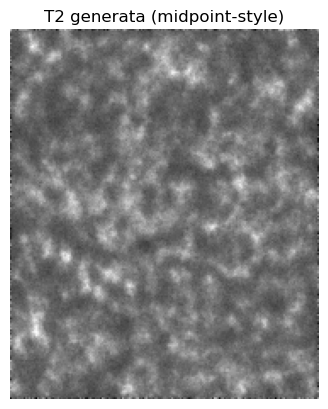

Training epoch 5: 100%|████████████████████████████████████████████████| 137/137 [00:10<00:00, 13.37it/s]


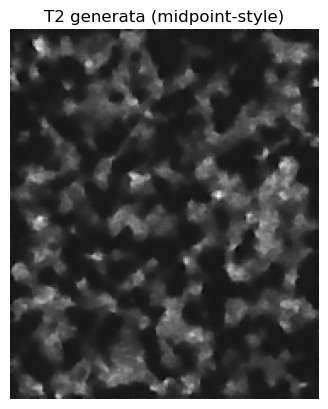

Training epoch 10: 100%|███████████████████████████████████████████████| 137/137 [00:10<00:00, 13.25it/s]


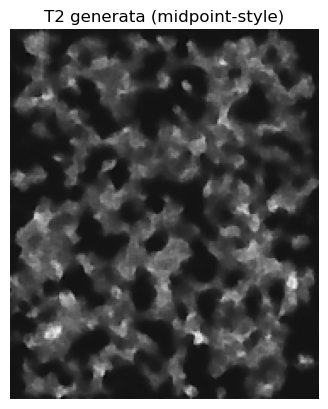

Epochs:   4%|██▏                                                        | 11/300 [01:54<50:21, 10.46s/it]

In [ ]:
from torchvision import transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.ToTensor(),  # Normalize to [0, 1]
])

dataset = UnifiedBrainDataset(root_dir=DATAPATH, transform=transform)
dataloader = DataLoader(dataset, batch_size=16, num_workers=4, shuffle=True)

flow = FlowCNN()

train_flow_from_dataset(flow, dataloader, exp_name="t2-generation 1000", n_epochs=1000)
